In [139]:
import os
import sys

from pathlib import Path


# si aggiunge al path la cartella utils per avere visibilità del module
module_path = Path(os.getcwd()).parent.parent
module_path = os.path.join(module_path, "project-detective")

sys.path.append(module_path)

In [140]:
import timm
import torch
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
import utils.mining as mining
import utils.build_dataset as build

from torch import nn
from tqdm import tqdm
from skimage import io
from sklearn.metrics import confusion_matrix
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [141]:
# serve per ricaricare automaticamente il codice modificato
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [142]:
# configurazione
BATCH_SIZE=32

LR=0.001

EPOCHS=30

DEVICE="cuda"

# per far funzionare il modello su immagini rgb o in scala di grigi (per usare fourier)
mode="rgb"

# semi-hard mining con modello pre-allenato
semi_hard="pretrained"

# margin per il semi-hard
margin=0.2

In [143]:
# directory da dove vengono prelevate le immagini
path = Path(os.getcwd()).parent.parent

fake_data_dir = os.path.join(path, "artifact", "taming_transformer")
real_data_dir = os.path.join(path, "artifact", "coco")

In [144]:
# carica le immagini nel dataset
class APN_Dataset(Dataset):

  def __init__(self, df):
    self.df = df

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]
    
    if mode == "rgb":
      # le immagini Anchor sono memorizzate in due dataset diversi
      if str(row.Anchor).startswith("coco"):
        A_img = io.imread(os.path.join(real_data_dir, row.Anchor))
        P_img = io.imread(os.path.join(real_data_dir, row.Positive))
        N_img = io.imread(os.path.join(fake_data_dir, row.Negative))

      else:
        A_img = io.imread(os.path.join(fake_data_dir, row.Anchor))
        P_img = io.imread(os.path.join(fake_data_dir, row.Positive))
        N_img = io.imread(os.path.join(real_data_dir, row.Negative))

      # normalizzazione per immagini in rgb 
      A_img = torch.from_numpy(A_img).permute(2, 0, 1) / 255.0
      P_img = torch.from_numpy(P_img).permute(2, 0, 1) / 255.0
      N_img = torch.from_numpy(N_img).permute(2, 0, 1) / 255.0

    if mode == "grey_scale":
      A_img = np.expand_dims(A_img, 0)
      P_img = np.expand_dims(P_img, 0)
      N_img = np.expand_dims(N_img, 0)
      
      A_img = torch.from_numpy(A_img) / 255.0
      P_img = torch.from_numpy(P_img) / 255.0
      N_img = torch.from_numpy(N_img) / 255.0

    # A_img = torch.from_numpy(A_img.astype(np.int32)) / 65536.0
    # P_img = torch.from_numpy(P_img.astype(np.int32)) / 65536.0
    # N_img = torch.from_numpy(N_img.astype(np.int32)) / 65536.0

    return A_img, P_img, N_img

In [145]:
# funzione per caricare il modello di rete neurale direttamente dalle repository online
class APN_Model(nn.Module):

  # size del vettore di embedding
  def __init__(self, emb_size = 512):
    super(APN_Model, self).__init__()

    # caricamento del modello, in questo caso efficientnet b0 (architettura più leggera della famiglia)
    if semi_hard == "not-pretrained":
      self.efficientnet = timm.create_model("tf_efficientnetv2_b0", pretrained=False)
    else:
      self.efficientnet = timm.create_model("tf_efficientnetv2_b0", pretrained=True)
    
    self.efficientnet.classifier = nn.Linear(in_features=self.efficientnet.classifier.in_features, out_features=emb_size)

  def forward(self, images):
    embeddings = self.efficientnet(images)
    return embeddings

In [146]:
# funzione per creare embeddings che sarranno sottoposti a semi-hard mining
def create_embeddings(model, dataloader, device): 
    # off dropout
    model.eval()

    list_df = []

    with torch.no_grad():
        for A, P, N in tqdm(dataloader, desc="creating embeddings..."):
            A, P, N = A.to(device), P.to(device), N.to(device)

            temp_df_embs = pd.DataFrame(columns=["Anchor_embs", "Positive_embs", "Negative_embs"])

            A_embs = model(A)
            P_embs = model(P)
            N_embs = model(N)
            
            # la batch size può variare 
            batch_size = len(A_embs)
            
            # ad ogni batch corrisponde un dataframe
            for i in range(batch_size): 
                # si serializzano gli array np in stringhe in modo da memorizzarli nelle celle del datagrame
                A, P, N = A_embs[i].cpu().numpy(), P_embs[i].cpu().numpy(), N_embs[i].cpu().numpy()
                A, P, N = np.array2string(A, separator=','), np.array2string(P, separator=','), np.array2string(N, separator=',')
                
                temp_df_embs.loc[i] = [
                    A, 
                    P, 
                    N
                ]
            
            list_df.append(temp_df_embs)

    # concatenazione di tutti i dataframe
    df_embs = pd.concat(list_df)

    return df_embs

In [147]:
emb_model = APN_Model()

# per processare le immagini in scala di grigi per fare fourier serve una CNN 2D
if mode == "grey_scale":
    emb_model.efficientnet.conv_stem = nn.Conv2d(1, 32, 3, 2, 1, bias=False)

if semi_hard == "not-pretrained":
    # caricamento modello precedentemente allenato su immagini del dataset artifact
    emb_model.load_state_dict(torch.load("emb_model.pt"))

emb_model.to(DEVICE)

APN_Model(
  (efficientnet): EfficientNet(
    (conv_stem): Conv2dSame(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): ConvBnAct(
          (conv): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNormAct2d(
            16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (drop_path): Identity()
        )
      )
      (1): Sequential(
        (0): EdgeResidual(
          (conv_exp): Conv2dSame(16, 64, kernel_size=(3, 3), stride=(2, 2), bias=False)
          (bn1): BatchNormAct2d(
            64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act)

In [148]:
path = Path(os.getcwd()).parent.parent
fake_data_path = os.path.join(path, "artifact", "taming_transformer", "metadata.csv")
real_data_path = os.path.join(path, "artifact", "coco", "metadata.csv")

# creo il dataset di test
df_out_path = os.path.join("..", "datasets", "out.csv")
build.train(fake_data_path, real_data_path, df_out_path, 50000)

building (negative anchor) dataframe...: 100%|██████████| 25000/25000 [00:28<00:00, 882.01it/s] 


In [149]:
df_out = pd.read_csv(df_out_path)

# si carica il dataset per creare gli embeddings
apn_dataset = APN_Dataset(df_out)
dataloader = DataLoader(apn_dataset, batch_size=BATCH_SIZE)

In [156]:
emb_csv_path = os.path.join("..", "datasets", "embeddings.csv")

# si controlla che siano stati già creati gli embeddings
if not Path(emb_csv_path).is_file():
    df_emb = create_embeddings(emb_model, dataloader, DEVICE)
    df_emb.to_csv(emb_csv_path, index=False)

else:
    df_emb = pd.read_csv(emb_csv_path)

In [157]:
# si concatenano i dataframe delle immagini e degli embeddings sulle colonne per poter filtrare le righe in logica di semi-hard mining
df = pd.concat([df_out, df_emb], axis=1)

# offline semi-hard mining dei triplets
df = mining.offline_semi_hard_mining(df, margin)
df = df.drop(["Anchor_embs", "Positive_embs", "Negative_embs"], axis=1)

In [158]:
# funzione di train
def train_fn(model, dataloader, optimizer, criterion):
  model.train()
  # on dropout 
  total_loss = 0.0

  for A, P, N in tqdm(dataloader, desc="model training..."):
    A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

    optimizer.zero_grad()

    # qui vengono creati gli embeddings, le cui distanze verranno calcolate dopo
    A_embs = model(A)
    P_embs = model(P)
    N_embs = model(N)

    # online hard mining dei triplets
    A_embs, P_embs, N_embs = mining.online_hard_mining(A_embs, P_embs, N_embs, BATCH_SIZE, DEVICE)

    # criterion è la funzione di loss
    loss = criterion(A_embs, P_embs, N_embs)
    loss.backward()
    
    optimizer.step()

    total_loss += loss.item()

    return total_loss / len(dataloader)


In [159]:
# funzione di evaluation
def eval_fn(model, dataloader, criterion):
  model.eval() 
  # off dropout
  total_loss = 0.0

  with torch.no_grad():
    for A, P, N in tqdm(dataloader, desc="model validating..."):
      A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

      A_embs = model(A)
      P_embs = model(P)
      N_embs = model(N)

      loss = criterion(A_embs, P_embs, N_embs)

      total_loss += loss.item()

    return total_loss / len(dataloader)

In [160]:
model = APN_Model()

# per processare le immagini in scala di grigi per fare fourier serve una CNN 2D
if mode == "grey_scale":
    model.efficientnet.conv_stem = nn.Conv2d(1, 32, 3, 2, 1, bias=False)

model.to(DEVICE)

APN_Model(
  (efficientnet): EfficientNet(
    (conv_stem): Conv2dSame(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): ConvBnAct(
          (conv): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNormAct2d(
            16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (drop_path): Identity()
        )
      )
      (1): Sequential(
        (0): EdgeResidual(
          (conv_exp): Conv2dSame(16, 64, kernel_size=(3, 3), stride=(2, 2), bias=False)
          (bn1): BatchNormAct2d(
            64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act)

In [161]:
# split del nuovo dataframe
train_df, valid_df = train_test_split(df, test_size=0.20, random_state=42)

trainset = APN_Dataset(train_df)
validset = APN_Dataset(valid_df)

trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE)

In [162]:
# triplet loss e adam
criterion = nn.TripletMarginLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [163]:
# training
best_valid_loss = np.Inf

training_epoch_loss = []
validation_epoch_loss = []

for i in range(EPOCHS):
  train_loss = train_fn(model, trainloader, optimizer, criterion)
  valid_loss = eval_fn(model, validloader, criterion)

  training_epoch_loss.append(train_loss)
  validation_epoch_loss.append(valid_loss)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), "best_model.pt")
    best_valid_loss = valid_loss
    print("successful weights saving...")

  print(f"epochs: {i+1}, train_loss: {train_loss}, valid_loss: {valid_loss}")

model validating...: 100%|██████████| 41/41 [01:25<00:00,  2.09s/it]


successful weights saving...
epochs: 1, train_loss: 0.006134969325153374, valid_loss: 0.932264416683011


model validating...: 100%|██████████| 41/41 [00:23<00:00,  1.75it/s]


epochs: 2, train_loss: 0.006134969325153374, valid_loss: 0.936309121003965


model validating...: 100%|██████████| 41/41 [00:22<00:00,  1.84it/s]


epochs: 3, train_loss: 0.006134969325153374, valid_loss: 0.9388020314821383


model validating...: 100%|██████████| 41/41 [00:22<00:00,  1.86it/s]


epochs: 4, train_loss: 0.006134969325153374, valid_loss: 0.9415515733928215


model validating...: 100%|██████████| 41/41 [00:21<00:00,  1.88it/s]


epochs: 5, train_loss: 0.006134969325153374, valid_loss: 0.9433592834123751


model validating...: 100%|██████████| 41/41 [00:21<00:00,  1.88it/s]


epochs: 6, train_loss: 0.006134969325153374, valid_loss: 0.9391942736579151


model validating...: 100%|██████████| 41/41 [00:21<00:00,  1.89it/s]


epochs: 7, train_loss: 0.006134969325153374, valid_loss: 0.9397630836905503


model validating...: 100%|██████████| 41/41 [00:21<00:00,  1.87it/s]


epochs: 8, train_loss: 0.006134969325153374, valid_loss: 0.9398769910742597


model validating...: 100%|██████████| 41/41 [00:21<00:00,  1.88it/s]


epochs: 9, train_loss: 0.006134969325153374, valid_loss: 0.9438222792090439


model validating...: 100%|██████████| 41/41 [00:21<00:00,  1.89it/s]


epochs: 10, train_loss: 0.006134969325153374, valid_loss: 0.9417971314453497


model validating...: 100%|██████████| 41/41 [00:21<00:00,  1.88it/s]


epochs: 11, train_loss: 0.006134969325153374, valid_loss: 0.942487556759904


model validating...: 100%|██████████| 41/41 [00:21<00:00,  1.89it/s]


epochs: 12, train_loss: 0.006134969325153374, valid_loss: 0.9476875299360694


model validating...: 100%|██████████| 41/41 [00:21<00:00,  1.88it/s]


epochs: 13, train_loss: 0.006134969325153374, valid_loss: 0.9523108165438582


model validating...: 100%|██████████| 41/41 [00:21<00:00,  1.89it/s]


epochs: 14, train_loss: 0.006134969325153374, valid_loss: 0.953949915199745


model validating...: 100%|██████████| 41/41 [00:21<00:00,  1.87it/s]


epochs: 15, train_loss: 0.006134969325153374, valid_loss: 0.9545985780111174


model validating...: 100%|██████████| 41/41 [00:21<00:00,  1.88it/s]


epochs: 16, train_loss: 0.006134969325153374, valid_loss: 0.9552416554311427


model validating...: 100%|██████████| 41/41 [00:21<00:00,  1.87it/s]


epochs: 17, train_loss: 0.006134969325153374, valid_loss: 0.951366811263852


model validating...: 100%|██████████| 41/41 [00:21<00:00,  1.87it/s]


epochs: 18, train_loss: 0.006134969325153374, valid_loss: 0.9504784418315422


model validating...: 100%|██████████| 41/41 [00:21<00:00,  1.88it/s]


epochs: 19, train_loss: 0.006134969325153374, valid_loss: 0.9520932290612197


model validating...: 100%|██████████| 41/41 [00:21<00:00,  1.87it/s]


epochs: 20, train_loss: 0.006134969325153374, valid_loss: 0.9515522863806748


model validating...: 100%|██████████| 41/41 [00:21<00:00,  1.87it/s]


epochs: 21, train_loss: 0.006134969325153374, valid_loss: 0.9524332822822943


model validating...: 100%|██████████| 41/41 [00:21<00:00,  1.88it/s]


epochs: 22, train_loss: 0.006134969325153374, valid_loss: 0.9490751914861726


model validating...: 100%|██████████| 41/41 [00:21<00:00,  1.87it/s]


epochs: 23, train_loss: 0.006134969325153374, valid_loss: 0.9481380305639128


model validating...: 100%|██████████| 41/41 [00:21<00:00,  1.87it/s]


epochs: 24, train_loss: 0.006134969325153374, valid_loss: 0.9510960811521949


model validating...: 100%|██████████| 41/41 [00:21<00:00,  1.86it/s]


epochs: 25, train_loss: 0.006134969325153374, valid_loss: 0.9489048661255255


model validating...: 100%|██████████| 41/41 [00:21<00:00,  1.87it/s]


epochs: 26, train_loss: 0.006134969325153374, valid_loss: 0.9515116185676761


model validating...: 100%|██████████| 41/41 [00:21<00:00,  1.88it/s]


epochs: 27, train_loss: 0.006134969325153374, valid_loss: 0.9530742182964231


model validating...: 100%|██████████| 41/41 [00:21<00:00,  1.89it/s]


epochs: 28, train_loss: 0.006134969325153374, valid_loss: 0.9522335572940547


model validating...: 100%|██████████| 41/41 [00:21<00:00,  1.88it/s]


epochs: 29, train_loss: 0.006134969325153374, valid_loss: 0.9530967473983765


model validating...: 100%|██████████| 41/41 [00:21<00:00,  1.87it/s]

epochs: 30, train_loss: 0.006134969325153374, valid_loss: 0.9538444716755937


<function matplotlib.pyplot.show(close=None, block=None)>

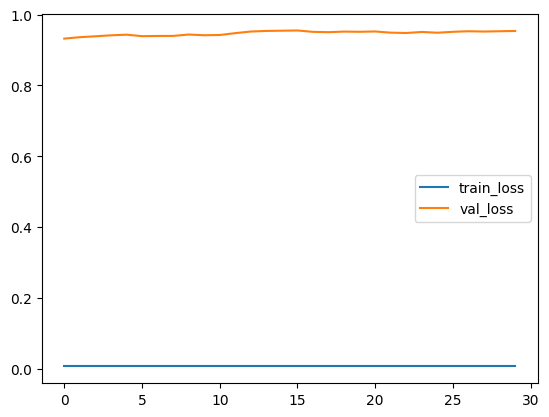

In [164]:
# plot della training e validation loss
plt.plot(training_epoch_loss, label="train_loss")
plt.plot(validation_epoch_loss, label="val_loss")
plt.legend()

plt.show

In [165]:
path = Path(os.getcwd()).parent.parent
fake_data_path = os.path.join(path, "artifact", "taming_transformer", "metadata.csv")
real_data_path = os.path.join(path, "artifact", "coco", "metadata.csv")

# creo il dataset di test
testList_df_path = os.path.join("..", "datasets", "testList.csv")
build.test(fake_data_path, real_data_path, testList_df_path, df)

building (fake column) test dataframe...: 100%|██████████| 1298/1298 [00:00<00:00, 1556.94it/s]


In [166]:
# funzione per generare i vettori di encoding
def get_encoding_csv(model, anc_img_names, dirFolder):
  anc_img_names_arr = np.array(anc_img_names)
  encodings = []

  model.eval()

  with torch.no_grad():
    for i in tqdm(anc_img_names_arr):

      if mode == "rgb":
        # serve per trovare correttamente l'immagine
        if str(i).startswith("coco"):
          dirFolder = real_data_dir
          A = io.imread(os.path.join(dirFolder,i))
        else: 
          dirFolder = fake_data_dir
          A = io.imread(os.path.join(dirFolder,i))

        A = torch.from_numpy(A).permute(2, 0, 1) / 255.0
      
      if mode == "grey_scale":
        A = io.imread(os.path.join(dirFolder,i))

        A = np.expand_dims(A, 0)
        A = torch.from_numpy(A.astype(np.int32)) / 255.0
        
      A = A.to(DEVICE)
      A_enc = model(A.unsqueeze(0))
      encodings.append(A_enc.squeeze().cpu().detach().numpy())

    encodings = np.array(encodings)
    encodings = pd.DataFrame(encodings)
    df_enc = pd.concat([anc_img_names, encodings], axis = 1)

    return df_enc

In [167]:
# per ricaricare il modello una volta allenato
model.load_state_dict(torch.load("best_model.pt"))

# si creano gli embeddings che vengono memorizzati per non rifarlo ad ogni allenamento
df_enc = get_encoding_csv(model, df["Anchor"], real_data_dir)
df_enc.to_csv("database.csv", index=False)

100%|██████████| 6491/6491 [03:21<00:00, 32.21it/s]


In [168]:
df_enc = pd.read_csv('database.csv')
df_enc.head()

C:\Users\raffa\AppData\Local\Temp\ipykernel_14092\2812054046.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df_enc = pd.read_csv('database.csv')


,Anchor,0,1,2,3,4,5,6,7,8,...,502,503,504,505,506,507,508,509,510,511
0,coco/coco2017/train2017/img058918.jpg,0.157157,0.203672,0.052145,0.217306,-0.139155,0.064487,0.173859,-0.057610,0.116458,...,0.304362,-0.401400,-0.215983,-0.295627,0.051768,0.141307,-0.022465,0.146743,-0.076202,0.013302
1,coco/coco2017/test2017/img007018.jpg,-0.145857,-0.042815,-0.072213,0.110568,-0.096990,0.069175,0.063797,0.147337,0.068751,...,-0.027794,0.044146,-0.151137,0.087140,0.025619,-0.053848,0.108014,-0.372928,0.102826,0.182472
2,coco/coco2017/test2017/img028366.jpg,0.093521,0.113159,0.123613,-0.024587,0.034392,0.356136,0.170422,-0.380300,-0.108335,...,-0.163030,0.019645,-0.021602,0.205957,-0.120609,-0.231020,-0.408108,0.110170,0.002949,0.272743
3,coco/coco2017/test2017/img038402.jpg,-0.095759,0.070045,0.091000,-0.168104,0.310452,0.157226,0.281537,0.099278,-0.206242,...,-0.007649,-0.099409,0.059086,0.085178,0.089127,-0.057004,-0.179769,0.018153,0.477837,0.131901
4,coco/coco2017/train2017/img055818.jpg,-0.034106,0.000396,0.203221,-0.197754,0.620051,0.288229,0.173201,-0.119365,-0.234051,...,0.116703,-0.237340,0.176252,0.004607,-0.338591,-0.063987,-0.033237,0.095705,-0.199152,0.103919


In [169]:
# approssimazione della distanza, senza la radice quadrata, per fare i primi allenamenti velocemente
def euclidean_dist(img_enc, anc_enc_arr):
    # dist = np.sqrt(np.dot(img_enc-anc_enc_arr, (img_enc- anc_enc_arr).T))
    dist = np.dot(img_enc-anc_enc_arr, (img_enc- anc_enc_arr).T)
    # dist = np.sqrt(dist)
    return dist

In [170]:
path = os.path.join(Path(os.getcwd()).parent, "datasets", "testList.csv")
df = pd.read_csv(path)

print(df["real"])
print(df.size)
df.head()

0        coco/coco2017/test2017/img037005.jpg
1       coco/coco2017/train2017/img149134.jpg
2        coco/coco2017/test2017/img033973.jpg
3         coco/coco2017/val2017/img163195.jpg
4        coco/coco2017/test2017/img022399.jpg
                        ...                  
1293     coco/coco2017/test2017/img002844.jpg
1294     coco/coco2017/test2017/img001583.jpg
1295     coco/coco2017/test2017/img036315.jpg
1296     coco/coco2017/test2017/img012010.jpg
1297    coco/coco2017/train2017/img110290.jpg
Name: real, Length: 1298, dtype: object
2596


,real,fake
0,coco/coco2017/test2017/img037005.jpg,tt-cc/cin_k600_p1.0_a0.05_fid5.20/806/img03931...
1,coco/coco2017/train2017/img149134.jpg,tt-ffhq/ffhq_k300_p1.0_fid9.6/img048247.jpg
2,coco/coco2017/test2017/img033973.jpg,tt-ffhq/ffhq_k300_p1.0_fid9.6/img038256.jpg
3,coco/coco2017/val2017/img163195.jpg,tt-ffhq/ffhq_k300_p1.0_fid9.6/img027204.jpg
4,coco/coco2017/test2017/img022399.jpg,tt-cc/cin_k600_p1.0_a0.05_fid5.20/955/img04756...


In [171]:
def getImageEmbeddings(img, model):
    if mode == "rgb":
        img = torch.from_numpy(img).permute(2, 0, 1) / 255.0
      
    if mode == "grey_scale":
        img = np.expand_dims(img, 0)
        img = torch.from_numpy(img) / 255
    
    model.eval()
    with torch.no_grad():
        img = img.to(DEVICE)
        img_enc = model(img.unsqueeze(0))
        img_enc = img_enc.detach().cpu().numpy()
        img_enc = np.array(img_enc)

    return img_enc

In [172]:
def searchInDatabase(img_enc, database):
    anc_enc_arr = database.iloc[:, 1:].to_numpy()
    anc_img_names = database["Anchor"]

    distance = []
    for i in range(anc_enc_arr.shape[0]):
        dist = euclidean_dist(img_enc, anc_enc_arr[i : i+1, :])
        distance = np.append(distance, dist)

    closest_idx = np.argsort(distance)

    return database["Anchor"][closest_idx[0]]

In [173]:
# DataTestReal = 'C:/Users/polsi/Desktop/Lavori/DeepFake/Datasets/Artifact/cycle_gan/st/test/'
path = Path(os.getcwd()).parent.parent
real_data_dir = os.path.join(path, "artifact", "coco")
fake_data_dir = os.path.join(path, "artifact", "taming_transformer")

y_true = []
y_pred = []

tempDf = df
tempDf.head()
tempDf.shape

(1298, 2)

In [174]:
# testo i fake
currentTest = "fake"
database = df_enc

# prendo i primi 500 Fake
for index, row in tqdm(tempDf.iterrows(), desc="testing on fake images..."):
    path = os.path.join(fake_data_dir, row[currentTest])
    img_name = path

    img = io.imread(img_name)

    img_enc = getImageEmbeddings(img, model)

    closestLabel = searchInDatabase(img_enc, database)

    if mode == "rgb":
        if str(closestLabel).startswith("coco"):
            y_pred.append("real")
        else:
            y_pred.append("fake")

    if mode == "grey_scale": 
        if "real" in closestLabel:
            y_pred.append("real")
        else:
            y_pred.append("fake")

testing on fake images...: 1298it [05:53,  3.67it/s]


In [175]:
print(len(y_true))
print(len(y_pred))
print(y_pred)

0
1298
['fake', 'fake', 'fake', 'fake', 'real', 'fake', 'real', 'fake', 'fake', 'fake', 'fake', 'fake', 'real', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'real', 'fake', 'fake', 'fake', 'fake', 'fake', 'real', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'real', 'real', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'real', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'real', 'real', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'real', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'real', 'fake', 'fake', 

In [176]:
# testo i real
currentTest = "real"
database = df_enc

# prendo i primi 500 Fake
for index, row in tqdm(tempDf.iterrows(), desc="testing on real images..."):
    path = os.path.join(real_data_dir, row[currentTest])
    img_name = path

    img = io.imread(img_name)

    img_enc = getImageEmbeddings(img, model)

    closestLabel = searchInDatabase(img_enc, database)
    
    if mode == "rgb":
        if str(closestLabel).startswith("coco"):
            y_pred.append("real")
        else:
            y_pred.append("fake")

    if mode == "grey_scale":
        if "real" in closestLabel:
            y_pred.append("real")
        else:
            y_pred.append("fake")


testing on real images...: 1298it [05:45,  3.76it/s]


In [177]:
print(len(y_true))
print(len(y_pred))
print(y_pred)

0
2596
['fake', 'fake', 'fake', 'fake', 'real', 'fake', 'real', 'fake', 'fake', 'fake', 'fake', 'fake', 'real', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'real', 'fake', 'fake', 'fake', 'fake', 'fake', 'real', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'real', 'real', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'real', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'real', 'real', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'real', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'real', 'fake', 'fake', 

In [178]:
# creo i vettori di ground truth
int(len(df) / 100 * 20)

y_true = np.array(["fake"] * (len(valid_df) - 1))
print(y_true.shape)

temp = np.array(["real"] * (len(valid_df) - 1))
print(temp.shape)

y_true = np.concatenate([y_true, temp])
print(y_true.shape)

# calcolo la matrice di confusione (quella di scikit-learn dispone i risultati come nella cella di sotto)
cm = confusion_matrix(y_true, y_pred, labels=["real", "fake"])
print(cm)

(1298,)
(1298,)
(2596,)
[[ 166 1132]
 [ 181 1117]]


In [179]:
TN, FP, FN, TP = cm.ravel()

# metriche
accuracy = round((TP + TN) / (TP + TN + FP + FN), 4) * 100
precision = round((TP) / (TP + FP), 4) * 100
recall = round((TP) / (TP + FN), 4) * 100
specificity = round((TN) / (TN + FP) * 100, 4)
f1_score = round((2 * precision * recall) / (precision + recall), 4)

print({"Accuracy":accuracy, "Precision":precision, "Recall":recall, "Specificity":specificity, "F1 Score":f1_score})

{'Accuracy': 49.419999999999995, 'Precision': 49.669999999999995, 'Recall': 86.06, 'Specificity': 12.7889, 'F1 Score': 62.9868}


In [180]:
# si salvano i risultati in un file .csv
df_results = pd.DataFrame(columns=["Accuracy", "Precision", "Recall", "Specificity", "F1 Score"])
df_results.loc[0] = [accuracy, precision, recall, specificity, f1_score]

# si differenziano i risultati in base al tipo di immagini e dataset usati
dataset = fake_data_dir.split("\\")[-1]
path = os.path.join("..", "results", "rgb_semi_hard", "siamese_" + mode + "_" + "semi_hard_" + semi_hard + "_" + dataset + "_results.csv")

df_results.to_csv(path, index=False)